## Loading of Packages and Libaries


In [ ]:
#import libraries
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Subset
import torch.nn as nn

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    )
])


In [ ]:
trainset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

valset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

## To get class balance across all the classes

In [ ]:
def get_class_balanced_subset(dataset, fraction, num_classes=10, seed=42):
    """
    fraction: e.g. 0.1, 0.2
    """
    np.random.seed(seed)

    targets = np.array(dataset.targets)
    indices = []

    for cls in range(num_classes):
        cls_indices = np.where(targets == cls)[0]
        n_select = int(len(cls_indices) * fraction)
        selected = np.random.choice(cls_indices, n_select, replace=False)
        indices.extend(selected)

    np.random.shuffle(indices)
    return Subset(dataset, indices)

In [ ]:
# #create train and val batches
# train_data = DataLoader(train_subset, batch_size=batch_size,
#                                           shuffle=True)


In [ ]:
# from collections import Counter

# labels = [trainset.targets[i] for i in train_subset.indices]
# print(Counter(labels))


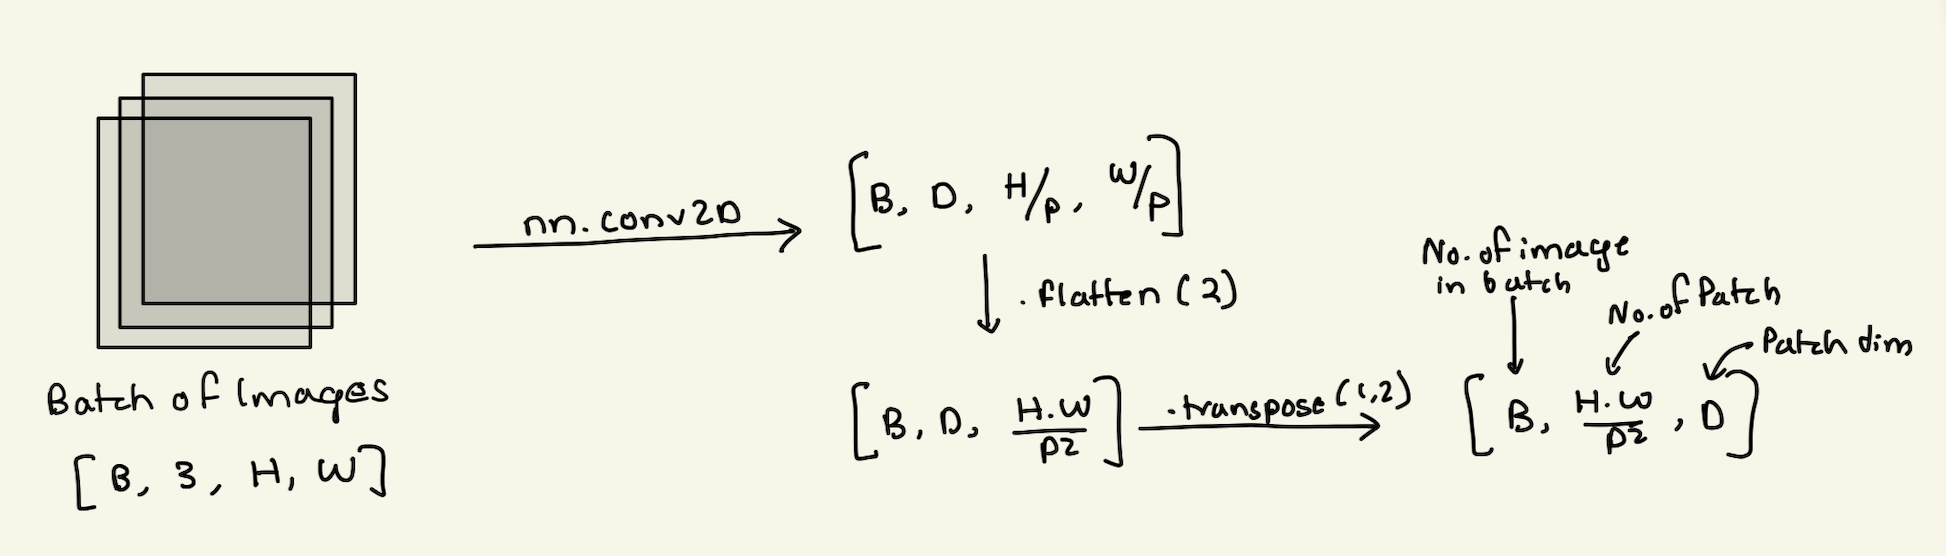

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, num_channels, embed_dim):
        super().__init__()
        self.patch_embed = nn.Conv2d(
            num_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x


In [ ]:
class TransformerArchitecture(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim):
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.self_attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.multi_layer_perceptron = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim)
        )

    def forward(self, x):

        residual_1 = x
        attention_output = self.self_attention(self.layer_norm_1(x),self.layer_norm_1(x),self.layer_norm_1(x))[0]
        x = attention_output + residual_1
        residual_2 = x
        mlp_output = self.multi_layer_perceptron(self.layer_norm_2(x))
        x = mlp_output + residual_2
        return x


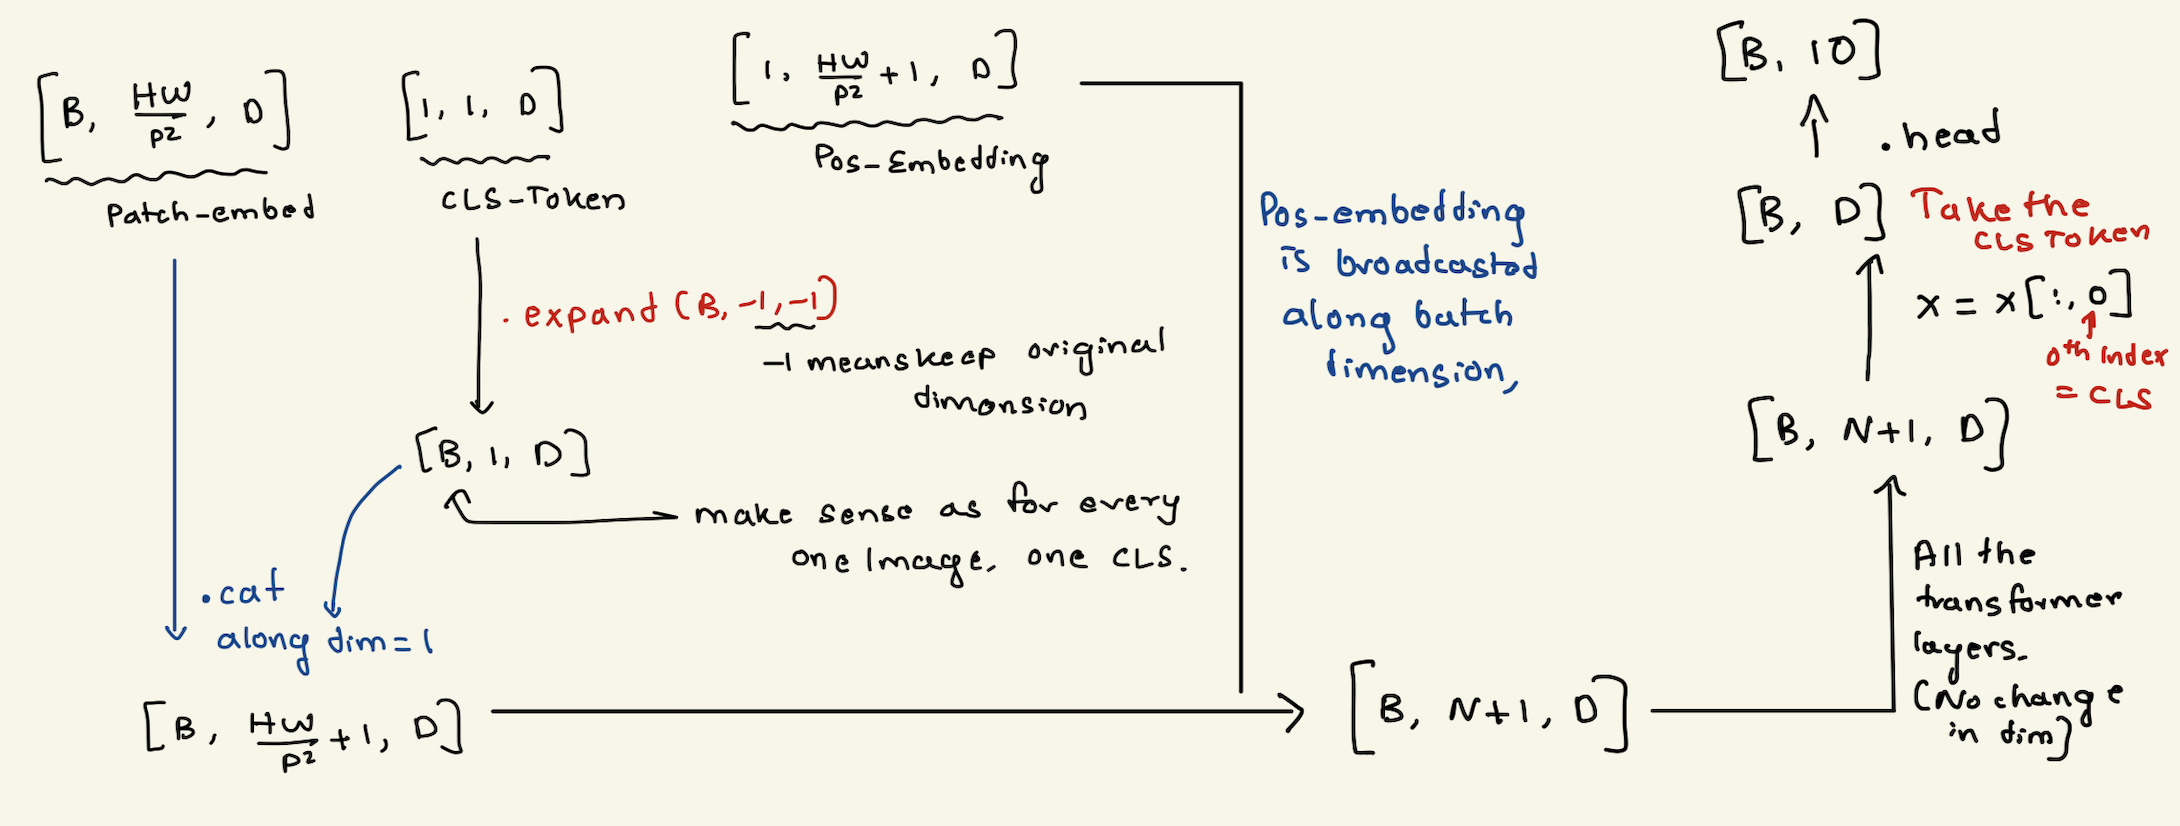

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, num_channels,
                 embed_dim, num_heads, mlp_dim, num_layers):
        super().__init__()

        self.patch_embed = PatchEmbedding(patch_size, num_channels, embed_dim)

        num_patches = (img_size // patch_size) ** 2

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))

        self.transformer = nn.Sequential(*[
            TransformerArchitecture(embed_dim, num_heads, mlp_dim)
            for _ in range(num_layers)
        ])

        self.head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, 10)
        )

    def forward(self, x):
        B = x.size(0)

        x = self.patch_embed(x)
        cls = self.cls_token.expand(B, -1, -1)

        x = torch.cat([cls, x], dim=1)
        x = x + self.pos_embed

        x = self.transformer(x)
        x = x[:, 0]          # CLS token
        return self.head(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
@torch.no_grad()
def evaluate(model, data_loader, device):
    model.eval()
    correct, total = 0, 0

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return 100.0 * correct / total


In [ ]:
def train_one_experiment(model, train_loader, device, epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return 100.0 * correct / total


In [ ]:
patch_sizes = [4, 8, 16]
subset_fractions = [0.2, 0.4, 0.6, 0.8, 1.0]
num_heads_list = [2, 4, 6, 8]

batch_size = 32
img_size = 32
num_channels = 3
embed_dim = 64
mlp_dim = 256
transformer_units = 4

val_loader = DataLoader(valset, batch_size=batch_size,
                                          shuffle=False)
results = []

for patch_size in patch_sizes:
    for subset_fraction in subset_fractions:
        train_subset = get_class_balanced_subset(trainset, subset_fraction)
        train_loader = DataLoader(
            train_subset,
            batch_size=batch_size,
            shuffle=True
        )

        for num_heads in num_heads_list:

            if embed_dim % num_heads != 0:
                continue

            print(f"\nRunning: Patch={patch_size}, "
                  f"Subset={int(subset_fraction*100)}%, "
                  f"Heads={num_heads}")

            model = VisionTransformer(
                img_size=img_size,
                patch_size=patch_size,
                num_channels=num_channels,
                embed_dim=embed_dim,
                num_heads=num_heads,
                mlp_dim=mlp_dim,
                num_layers=transformer_units
            ).to(device)

            train_acc = train_one_experiment(model, train_loader, device)
            val_acc = evaluate(model, val_loader, device)

            results.append({
                "patch_size": patch_size,
                "subset": subset_fraction,
                "heads": num_heads,
                "train_accuracy": train_acc,
                "val_accuracy": val_acc
            })

            print(f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


In [ ]:
import pandas as pd

df = pd.DataFrame(results)
df


In [ ]:
df.to_csv("output_64_256.csv", index=False)


In [ ]:
import matplotlib.pyplot as plt

patch_plot = (
    df.groupby("patch_size")["val_accuracy"]
    .mean()
    .reset_index()
)

plt.figure()
plt.plot(patch_plot["patch_size"], patch_plot["val_accuracy"], marker="o")
plt.xlabel("Patch Size")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Patch Size (averaged over subsets & heads)")
plt.grid(True)
plt.show()


In [ ]:
subset_plot = (
    df.groupby("subset")["val_accuracy"]
    .mean()
    .reset_index()
)

plt.figure()
plt.plot(subset_plot["subset"] * 100, subset_plot["val_accuracy"], marker="o")
plt.xlabel("Training Data (%)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Training Data Fraction")
plt.grid(True)
plt.show()


In [ ]:
heads_plot = (
    df.groupby("heads")["val_accuracy"]
    .mean()
    .reset_index()
)

plt.figure()
plt.plot(heads_plot["heads"], heads_plot["val_accuracy"], marker="o")
plt.xlabel("Number of Attention Heads")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Number of Attention Heads")
plt.grid(True)
plt.show()
